# Обучение классификатора

In [1]:
# система, работа с файлами
import os
import sys
from pathlib import Path
from os import walk

# вычисления
import numpy as np
import statistics

# изображения
from matplotlib import pyplot as plt

# дата и время
import datetime


#ML
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
tf.__version__

'2.6.0'

## Константы

In [3]:
#Определение корневой директории проекта
FILE = Path().resolve()
ROOT_DIR = os.path.join(FILE.parents[1])

# Директории с данными
DATA_DIR = os.path.join(ROOT_DIR, 'data')
TRAIN_DATA_CLEAN_DIR = os.path.join(DATA_DIR, 'train', 'clean')
TRAIN_DATA_NOISY_DIR = os.path.join(DATA_DIR, 'train', 'noisy')
VAL_DATA_CLEAN_DIR = os.path.join(DATA_DIR, 'val', 'clean')
VAL_DATA_NOISY_DIR = os.path.join(DATA_DIR, 'val', 'noisy')
# Директория с весами
WEIGHTS_DIR = os.path.join(ROOT_DIR, 'weights')

# Параметры данных для обучения
# Высота спектрограммы
SPEC_HEIGHT = 80
# Максимальная длина спектрограммы
SPEC_MAX_LENGTH = 80#800
# Количество пар (чистые/зашумленные) примеров для обучения
TRAIN_CNT = 1000
VAL_CNT = int(round(0.2 * TRAIN_CNT))


# Параметры модели 
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 50
EPOCHS = 50
LEARNING_RATE = 0.001

## Подготовка данных

Посмотрим исходные данные

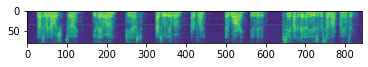

In [4]:
test_clean_file_path = os.path.join(VAL_DATA_CLEAN_DIR, '1084', '1084_139230_1084-139230-0014.npy')

with open(test_clean_file_path, 'rb') as f:
    test_clean = np.load(f).astype('float32')

plt.imshow(test_clean.T)

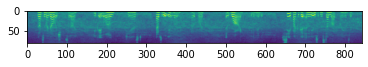

In [5]:
test_noisy_file_path = os.path.join(VAL_DATA_NOISY_DIR, '1084', '1084_139230_1084-139230-0014.npy')

with open(test_noisy_file_path, 'rb') as f:
    test_noisy = np.load(f).astype('float32')

plt.imshow(test_noisy.T)

уберем шум

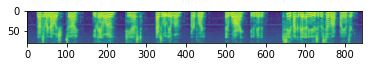

In [6]:
clean = 2 * test_clean - test_noisy
plt.imshow(clean.T)

### Загрузка исходных данных

In [7]:
def load_spec_data(p_dir):
    """
    Загрузка данных из файлов
    :param p_dir: путь к целевой директории
    
    :return spec_list: список спектрограмм
    :return stat: max, min, avg, med длина спектрограммы 
    """
    
    files_paths = []
    lengths = []
    for (dirpath, dirnames, filenames) in walk(p_dir):
        for filename in filenames:
            files_paths.append(os.path.join(dirpath, filename))
    
    spec_list = []
    for file_path in files_paths:
        with open(file_path, 'rb') as f:
            # добавляем измерения для канала, чтобы было похоже на изображение, которое можно подать в CNN
            spec = np.expand_dims(np.load(f).astype('float32'), axis=2)
    
        spec_list.append(spec)
        lengths.append(spec.shape[0])

    # for
    
    stat ={'max': max(lengths),
           'min': min(lengths),
           'mean': statistics.mean(lengths),
           'mean': statistics.median(lengths),
           'mode': statistics.median(lengths),
    }
        
    return spec_list, stat
    
    
# load_spec_data

In [8]:
# загружаем данные
train_clean_spec_list, train_stat_length = load_spec_data(TRAIN_DATA_CLEAN_DIR)
train_noisy_spec_list, _ = load_spec_data(TRAIN_DATA_NOISY_DIR)
val_clean_spec_list, val_stat_length = load_spec_data(VAL_DATA_CLEAN_DIR)
val_noisy_spec_list, _ = load_spec_data(VAL_DATA_NOISY_DIR)

print(train_stat_length)
print(val_stat_length)

{'max': 1374, 'min': 52, 'mean': 857.0, 'mode': 857.0}
{'max': 1226, 'min': 113, 'mean': 853.0, 'mode': 853.0}


In [9]:
def transform_spec(p_spec, p_spec_max_length):
    """
    Преобразование спектрограммы к формату для подачи в модели
    
    :param p_spec: спектрограмма
    :param p_spec_max_length: максимальная длина спектрограммы
    
    :return: спектограмма в формате numpy array (p_spec_max_length, 80, 1) dtype=float32
    """
    
    spec = p_spec.copy()
    if spec.dtype != 'float32':
        spec = p_spec.astype('float32')
    if len(spec.shape)==2:
        spec = np.expand_dims(spec, axis=2)
        
        
    # добавляем до p_spec_max_length
    if spec.shape[0] < p_spec_max_length:
        spec = np.append(spec, 
                         np.zeros((p_spec_max_length - spec.shape[0],
                         spec.shape[1],
                         spec.shape[2])), axis=0)
        
    # отрезаем до p_spec_max_length
    elif spec.shape[0] > p_spec_max_length:
        spec = spec[:p_spec_max_length,:,:]           

            
    return spec
    
    
# transform_spec

In [10]:
def create_dataset(p_clean_spec_list, p_noisy_spec_list, p_spec_max_length):
    """
    Трансформация исходных данных в формат датасета для обучения
    
    :param p_clean_spec_list: списк чистых спектрограмм
    :param p_noisy_spec_list: списк зашумленных спектрограмм
    :param p_spec_max_length: максимальная длинна спектрограммы
    
    :return features_ds: массив фич
    :return labels_ds: массив меток
    """
    
    features_cnt = (len(p_clean_spec_list) + len(p_noisy_spec_list))
    features_ds = np.zeros((features_cnt,
                            p_spec_max_length, 
                            p_clean_spec_list[0].shape[1], 
                            p_clean_spec_list[0].shape[2]), dtype='float32')
    
    labels_ds = np.concatenate((np.zeros((len(p_clean_spec_list), 1), dtype='int32'), 
                                np.ones((len(p_noisy_spec_list), 1), dtype='int32')))
    
    index = 0
    for spec in p_clean_spec_list:
        features_ds[index] = transform_spec(spec, p_spec_max_length)
        index += 1        
        
    # for
    
    for spec in p_noisy_spec_list:
        features_ds[index] = transform_spec(spec, p_spec_max_length) 
        index += 1        
        
    # for
    
    
    return features_ds, labels_ds
    
# create_dataset

In [11]:
train_ds, train_labels = create_dataset(train_clean_spec_list[:TRAIN_CNT], 
                                        train_noisy_spec_list[:TRAIN_CNT], 
                                        SPEC_MAX_LENGTH)

val_ds, val_labels = create_dataset(val_clean_spec_list[:VAL_CNT], 
                                    val_noisy_spec_list[:VAL_CNT], 
                                    SPEC_MAX_LENGTH)

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((val_ds, val_labels))
val_ds = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

## Создание и обучение модели

In [13]:
input_shape = (SPEC_MAX_LENGTH, SPEC_HEIGHT, 1)

In [14]:
#вариант 80*80
model = tf.keras.models.Sequential([
tf.keras.layers.Input(shape=input_shape), 
tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [15]:
#вариант 800*80
#model = tf.keras.models.Sequential([
#tf.keras.layers.Input(shape=input_shape),
#tf.keras.layers.Resizing(200, 200),    
#tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
#tf.keras.layers.MaxPooling2D(2, 2),
#tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#tf.keras.layers.MaxPooling2D(2,2),
#tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#tf.keras.layers.MaxPooling2D(2,2),
#tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#tf.keras.layers.MaxPooling2D(2,2),
#tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#tf.keras.layers.MaxPooling2D(2,2),
#tf.keras.layers.Flatten(),
#tf.keras.layers.Dense(512, activation='relu'),
#tf.keras.layers.Dense(1, activation='sigmoid')])
    
#model.summary()

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics='accuracy')

In [17]:
checkpoint_name = '{}_cnn_noise_catcher_best'.format(datetime.datetime.now().strftime('%Y-%m-%d-%H%M%S'))
checkpoint_path = os.path.join(WEIGHTS_DIR, checkpoint_name)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor= 'val_accuracy',
                                                verbose= 1, 
                                                save_best_only= True, 
                                                mode='max')

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [checkpoint])

Epoch 1/50
32/32 [==============================] - 4s 110ms/step - loss: 3.5186 - accuracy: 0.7000 - val_loss: 0.7029 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /home/mkm/Projects/GOSZNAK_SoundCleaner/weights/2022-04-08-095212_cnn_noise_catcher_best
INFO:tensorflow:Assets written to: /home/mkm/Projects/GOSZNAK_SoundCleaner/weights/2022-04-08-095212_cnn_noise_catcher_best/assets
Epoch 2/50
32/32 [==============================] - 4s 113ms/step - loss: 0.7100 - accuracy: 0.3110 - val_loss: 0.6905 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/50
32/32 [==============================] - 4s 118ms/step - loss: 0.7183 - accuracy: 0.4670 - val_loss: 0.6674 - val_accuracy: 0.8325

Epoch 00003: val_accuracy improved from 0.50000 to 0.83250, saving model to /home/mkm/Projects/GOSZNAK_SoundCleaner/weights/2022-04-08-095212_cnn_noise_catcher_best
INFO:tensorflow:Assets written to: /home/mkm/Projects/GOSZ

Epoch 28/50
32/32 [==============================] - 3s 104ms/step - loss: 0.1950 - accuracy: 0.9250 - val_loss: 0.1532 - val_accuracy: 0.9525

Epoch 00028: val_accuracy did not improve from 0.95250
Epoch 29/50
32/32 [==============================] - 4s 122ms/step - loss: 0.1894 - accuracy: 0.9300 - val_loss: 0.1570 - val_accuracy: 0.9475

Epoch 00029: val_accuracy did not improve from 0.95250
Epoch 30/50
32/32 [==============================] - 4s 111ms/step - loss: 0.1683 - accuracy: 0.9390 - val_loss: 0.1449 - val_accuracy: 0.9500

Epoch 00030: val_accuracy did not improve from 0.95250
Epoch 31/50
32/32 [==============================] - 4s 118ms/step - loss: 0.1753 - accuracy: 0.9355 - val_loss: 0.1483 - val_accuracy: 0.9525

Epoch 00031: val_accuracy did not improve from 0.95250
Epoch 32/50
32/32 [==============================] - 4s 115ms/step - loss: 0.1627 - accuracy: 0.9410 - val_loss: 0.1460 - val_accuracy: 0.9575

Epoch 00032: val_accuracy improved from 0.95250 to 0.95750, 

### Посмотрим метрики обучения

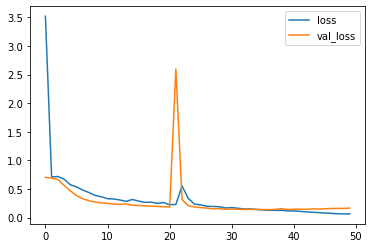

In [22]:
# написать функцию вывода графиков рядом (loss, accuracy)

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

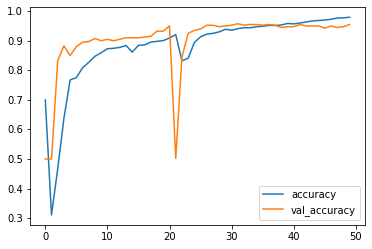

In [23]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### Тест модели

загрузим модель

In [24]:
WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, checkpoint_path)
noise_catcher = tf.keras.models.load_model(WEIGHTS_PATH)

Сформируем набор для проверки

In [25]:
start = VAL_CNT+1
end = VAL_CNT+11
test_clean = val_clean_spec_list[start:end]
test_noisy = val_noisy_spec_list[start:end]

проверка на чистых записях

In [26]:
for spec in test_clean: 
    spec = transform_spec(spec, SPEC_MAX_LENGTH)
    spec = np.expand_dims(spec, axis=0)
    
    proba = noise_catcher.predict(spec)
    if round(proba[0][0]) == 0:
        print ('нет шумов - правильно!')
    else:
        print ('зашумленная запись - ошибка!')
    
#for

нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
нет шумов - правильно!
зашумленная запись - ошибка!


проверка на зашумленных записях

In [27]:
for spec in test_noisy: 
    spec = transform_spec(spec, SPEC_MAX_LENGTH)
    spec = np.expand_dims(spec, axis=0)
    
    proba = noise_catcher.predict(spec)
    if round(proba[0][0]) == 1:
        print ('зашумленная запись - правильно!')
    else:
        print ('нет шумов - ошибка!')
    
#for

зашумленная запись - правильно!
зашумленная запись - правильно!
нет шумов - ошибка!
зашумленная запись - правильно!
зашумленная запись - правильно!
нет шумов - ошибка!
зашумленная запись - правильно!
зашумленная запись - правильно!
зашумленная запись - правильно!
зашумленная запись - правильно!
